**Justification :**

Intuitivement, on a tendance à penser que les conditions pour qu'il pleuve, même peu, ne sont pas les mêmes que les conditions pour qu'il pleuve beaucoup *(> 1mm)*.
Cela signifie qu'au lieu d'analyser deux classes *(pluie <= 1mm)* et *(pluie > 1mm)*, il pourrait être intéressant de séparer le problème en trois classes *(pluie = 0mm), (0mm < pluie <= 1mm)* et *(pluie > 1mm)*.

Evidemment, les deux premières nouvelles classes correspondent à l'ancienne première classe, ce qui fait que si l'on se contente de rester sur une simple classification en trois classes, on ne gagnera rien, hormis peut-être une interprétation un peu plus fine du phénomène.

L'idée est de construire un modèle "hurdle", c'est-à-dire qu'il faut d'abord être dans les conditions d'existence de pluie *(!= 0mm)*, puis d'être dans les conditions d'une pluie forte *(> 1mm)*. On peut voir la chose comme une simple application de probabilités conditionnelles :

P(pluie > 1mm) = P(pluie != 0) * P(pluie > 1mm | pluie != 0).

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import r_regression
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier

##Chargement des données et nettoyage

In [ ]:
df_full = pd.read_csv("https://raw.githubusercontent.com/ArnoMac/weatherAUS/main/weatherAUS_Kapy_v2.csv", parse_dates=['Date'], index_col=0)
df = df_full.drop(columns=['DayOfYear','Month','Latitude','Longitude','DeltaP_1d', 'DeltaP_2d', 'DeltaH_1d', 'DeltaH_2d'])
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119245 entries, 0 to 145456
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Date                    119245 non-null  datetime64[ns]
 1   Location                119245 non-null  object        
 2   Rainfall                119245 non-null  float64       
 3   WindGustSpeed           119245 non-null  float64       
 4   Temp9am                 119245 non-null  float64       
 5   RainTomorrow            119245 non-null  float64       
 6   diffTempMinMax          119245 non-null  float64       
 7   diffWind3pm9am          119245 non-null  float64       
 8   diffPressure9am3pm      119245 non-null  float64       
 9   Pressure                119245 non-null  float64       
 10  DeltaP_3d               119245 non-null  float64       
 11  diffHimidity9am3pm      119245 non-null  float64       
 12  Humidity                119245

## Création d'un modèle simple de référence

###Séparation des données en train/test à 80/20 dans le temps

In [ ]:
df_train = df[df['Date']<'2016-01-01']
df_test = df[df['Date']>='2016-01-01']
X_train = df_train.drop('RainTomorrow', axis=1)
y_train = df_train['RainTomorrow']
X_test = df_test.drop('RainTomorrow', axis=1)
y_test = df_test['RainTomorrow']

In [ ]:
def scale_train_test(X_train, X_test, cols_to_scale):
  scaler = StandardScaler()
  scaler.fit(X_train[cols_to_scale])
  X_train_scaled = X_train.copy()
  X_test_scaled = X_test.copy()
  X_train_scaled[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
  X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
  return X_train_scaled, X_test_scaled

In [ ]:
X_train = X_train.drop(columns=['Date', 'Location'])
X_test = X_test.drop(columns=['Date', 'Location'])
cols_to_scale = X_train.columns[:13].values
print("Colonnes à standardiser :", cols_to_scale)
X_train_scaled, X_test_scaled = scale_train_test(X_train, X_test, cols_to_scale)

Colonnes à standardiser : ['Rainfall' 'WindGustSpeed' 'Temp9am' 'diffTempMinMax' 'diffWind3pm9am'
 'diffPressure9am3pm' 'Pressure' 'DeltaP_3d' 'diffHimidity9am3pm'
 'Humidity' 'DeltaH_3d' 'WindDirInfluence' 'consecutiveRainingDays']


In [ ]:
def plot_confusion_matrix(y_true, y_pred, display_labels):
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='all', display_labels=display_labels, values_format='.3g')
    disp.figure_.set(figwidth=3, figheight=3)
    plt.show()

###Entrainement d'un modèle de régression logistique à deux classes
On tient compte du caractère déséquilibré des données par rapport aux deux classes, et on va utiliser le score F1 comme métrique à la fois pour contrer ce caractère déséquilibré, et parce qu'on est particulièrement intéressé par la détection des cas de pluie.

In [ ]:
lr = LogisticRegressionCV(Cs=np.geomspace(0.01, 0.1, 10), class_weight='balanced', scoring='f1', cv=5, random_state=42, n_jobs=-1)
lr.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=array([0.01      , 0.0129155 , 0.01668101, 0.02154435, 0.02782559,
       0.03593814, 0.04641589, 0.05994843, 0.07742637, 0.1       ]),
                     class_weight='balanced', cv=5, n_jobs=-1, random_state=42,
                     scoring='f1')

F1-score = 0.6317


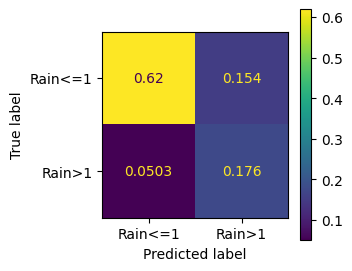

In [ ]:
y_pred = lr.predict(X_test_scaled)
print('F1-score =', round(f1_score(y_test, y_pred), 4))
plot_confusion_matrix(y_test, y_pred, display_labels=['Rain<=1', 'Rain>1'])

On obtient un score F1 de 0.63 qui servira de référence pour les modèles plus complexes.

On peut aussi s'intéresser aux variables les plus pertinentes de ce modèle :

In [ ]:
pd.Series(data=lr.coef_[0], index=X_train.columns).sort_values(ascending=False, key=np.abs).head(10)

Humidity              1.696116
Pressure             -1.150045
diffPressure9am3pm   -0.740252
Climate_Aw           -0.716651
Climate_BSh           0.538231
WindGustSpeed         0.524257
Climate_Am           -0.499292
WindDirInfluence      0.460935
Climate_BSk           0.448156
Climate_BWh           0.384822
dtype: float64

## Modèle "hurdle"
On va maintenant construire un modèle basé sur deux sous-modèles : un qui détecte la présence ou non de plui, et l'autre qui détecte si la pluie est supérieure à 1mm, **sachant** qu'il pleut.

In [ ]:
df = df_full.drop(columns=['DayOfYear','Month','Location', 'Latitude','Longitude','DeltaP_1d', 'DeltaP_2d', 'DeltaH_1d', 'DeltaH_2d'])
df['RainfallTomorrow'] = df_full['Rainfall'].shift(-1)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119244 entries, 0 to 145456
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Date                    119244 non-null  datetime64[ns]
 1   Rainfall                119244 non-null  float64       
 2   WindGustSpeed           119244 non-null  float64       
 3   Temp9am                 119244 non-null  float64       
 4   RainTomorrow            119244 non-null  float64       
 5   diffTempMinMax          119244 non-null  float64       
 6   diffWind3pm9am          119244 non-null  float64       
 7   diffPressure9am3pm      119244 non-null  float64       
 8   Pressure                119244 non-null  float64       
 9   DeltaP_3d               119244 non-null  float64       
 10  diffHimidity9am3pm      119244 non-null  float64       
 11  Humidity                119244 non-null  float64       
 12  DeltaH_3d               119244

###Séparation des données en train/test pour les deux modèles

In [ ]:
drop_cols = ['Date', 'RainTomorrow', 'RainfallTomorrow']

# Données du premier modèle

df_train = df[df['Date']<'2016-01-01']
df_test = df[df['Date']>='2016-01-01']

X_train_switch = df_train.drop(columns=drop_cols)
y_train_switch = df_train['RainfallTomorrow'].gt(0)
X_test_switch = df_test.drop(columns=drop_cols)
y_test_switch = df_test['RainfallTomorrow'].gt(0)

# Données du second modèle: on l'entraine uniquement sur les cas où il pleut

df_train_nonzero = df_train[df_train['RainfallTomorrow']>0]
df_test_nonzero = df_test[df_test['RainfallTomorrow']>0]

X_train_nonzero = df_train_nonzero.drop(columns=drop_cols)
y_train_nonzero = df_train_nonzero['RainTomorrow']
X_test_nonzero = df_test_nonzero.drop(columns=drop_cols)
y_test_nonzero = df_test_nonzero['RainTomorrow']

y_test = df_test['RainTomorrow']

In [ ]:
X_train_switch_scaled, X_test_switch_scaled = scale_train_test(X_train_switch, X_test_switch, cols_to_scale)
X_train_nonzero_scaled, X_test_nonzero_scaled = scale_train_test(X_train_nonzero, X_test_nonzero, cols_to_scale)

###Entrainement du premier modèle

In [ ]:
lr_switch = LogisticRegressionCV(Cs=np.geomspace(0.0001, 0.001, 10), class_weight='balanced', scoring='f1', cv=5, random_state=42, n_jobs=-1)
lr_switch.fit(X_train_switch_scaled, y_train_switch)
print(lr_switch.C_[0])

0.0005994842503189409


F1-score = 0.6995


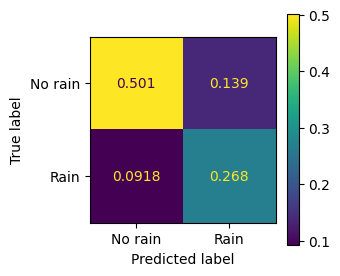

In [ ]:
y_pred_switch = lr_switch.predict(X_test_switch_scaled)
print('F1-score =', round(f1_score(y_test_switch, y_pred_switch), 4))

plot_confusion_matrix(y_test_switch, y_pred_switch, display_labels=['No rain', 'Rain'])

###Entrainement du second modèle
Ce modèle est entrainé sur un sous-ensemble des données pour lesquelles on sait qu'il pleut une quantité non nulle de pluie.

In [ ]:
lr_nonzero = LogisticRegressionCV(Cs=np.geomspace(0.001, 0.01, 10), class_weight='balanced', scoring='f1', cv=5, random_state=42, n_jobs=-1)
lr_nonzero.fit(X_train_nonzero_scaled, y_train_nonzero)
print(lr_nonzero.C_[0])

0.005994842503189409


F1-score = 0.7273


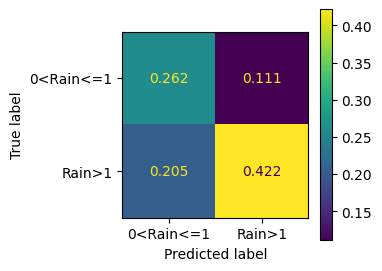

In [ ]:
y_pred_nonzero = lr_nonzero.predict(X_test_nonzero_scaled)
print('F1-score =', round(f1_score(y_test_nonzero, y_pred_nonzero), 4))
plot_confusion_matrix(y_test_nonzero, y_pred_nonzero, display_labels=['0<Rain<=1', 'Rain>1'])

On obtient deux scores F1 encourageants.

Il reste à combiner les deux résultats conformément à la formule des probabilités conditionnelles pour obtenir la prédiction combinée.

F1-score = 0.6147


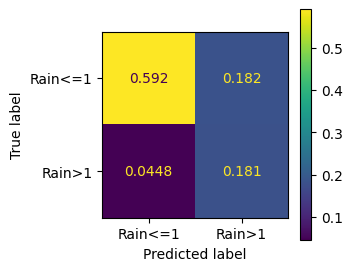

In [ ]:
y_pred_nonzero_full = lr_nonzero.predict(X_test_switch_scaled)
y_pred = y_pred_switch * y_pred_nonzero_full
print('F1-score =', round(f1_score(y_test, y_pred), 4))
plot_confusion_matrix(y_test, y_pred, display_labels=['Rain<=1', 'Rain>1'])

Le score F1 n'est malheureusement pas meilleur que celui obtenu avec un modèle de régression simple.

On peut cependant s'intéresser aux variables pertinentes des deux modèles :

In [ ]:
pd.Series(data=lr_switch.coef_[0], index=X_train_switch.columns).sort_values(ascending=False, key=np.abs).head(5)

Humidity              0.640975
diffHimidity9am3pm    0.400911
WindDirInfluence      0.372347
Pressure             -0.353363
WindGustSpeed         0.312705
dtype: float64

In [ ]:
pd.Series(data=lr_nonzero.coef_[0], index=X_train_nonzero.columns).sort_values(ascending=False, key=np.abs).head(5)

Pressure             -0.850132
diffPressure9am3pm   -0.592305
diffHimidity9am3pm    0.423366
WindGustSpeed         0.412948
Humidity              0.394343
dtype: float64

On peut remarquer que l'absence ou la présence de pluie est surtout provoquée par une forte teneur en humidité et sa variation à la hausse, tandis que la différence entre des pluies faibles et des pluies fortes est provoquée par une pression basse et la variation à la baisse de la pression.

Bien que ça n'améliore pas le score F1, c'est un résultat intéressant que l'on peut extraire de cette modélisation.

##Entrainement d'un modèle basé sur les random forest
Afin de dépasser le modèle de régression linéaire, on va appliquer la même approche avec un modèle basé sur les random forest.

In [ ]:
rf = BalancedRandomForestClassifier(class_weight='balanced', random_state=42)
parameters = {'n_estimators':[100, 200, 500], 'max_features':['sqrt', 8, 9, 10]}

In [ ]:
clf_switch = GridSearchCV(estimator=rf, param_grid=parameters, scoring='f1', cv=3, n_jobs=-1)
clf_switch.fit(X_train_switch_scaled, y_train_switch)

/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved f

GridSearchCV(cv=3,
             estimator=BalancedRandomForestClassifier(class_weight='balanced',
                                                      random_state=42),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt', 8, 9, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='f1')

F1-score = 0.7177


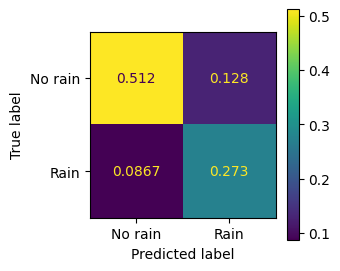

In [ ]:
y_pred_switch = clf_switch.predict(X_test_switch_scaled)
print('F1-score =', round(f1_score(y_test_switch, y_pred_switch), 4))

plot_confusion_matrix(y_test_switch, y_pred_switch, display_labels=['No rain', 'Rain'])

In [ ]:
clf_nonzero = GridSearchCV(estimator=rf, param_grid=parameters, scoring='f1', cv=3, n_jobs=-1)
clf_nonzero.fit(X_train_nonzero_scaled, y_train_nonzero)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel

GridSearchCV(cv=3,
             estimator=BalancedRandomForestClassifier(class_weight='balanced',
                                                      random_state=42),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt', 8, 9, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='f1')

F1-score = 0.7415


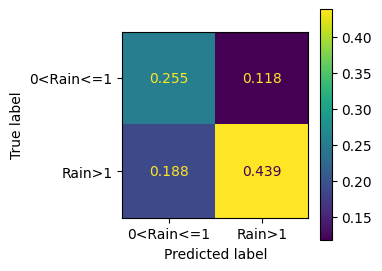

In [ ]:
y_pred_nonzero = clf_nonzero.predict(X_test_nonzero_scaled)
print('F1-score =', round(f1_score(y_test_nonzero, y_pred_nonzero), 4))
plot_confusion_matrix(y_test_nonzero, y_pred_nonzero, display_labels=['0<Rain<=1', 'Rain>1'])

F1-score = 0.6288


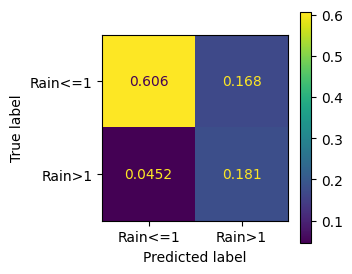

In [ ]:
y_pred_nonzero_full = clf_nonzero.predict(X_test_switch_scaled)
y_pred = y_pred_switch * y_pred_nonzero_full
print('F1-score =', round(f1_score(y_test, y_pred), 4))
plot_confusion_matrix(y_test, y_pred, display_labels=['Rain<=1', 'Rain>1'])

On obtient un score F1 à peine au-dessus du score de la régression logistique.